In [1]:
from yolo3.utils import mc3_get_random_data,get_random_data_own
import json

In [2]:
im_dir = '/data/mc_data/images_12k/'
json_path = '../annotations/MC3_train.json'
f = open(json_path,'r')
infos = json.load(f)
f.close()

In [3]:
info = infos[0]

In [11]:
im1,bx1 = mc3_get_random_data(im_dir,info,(480,640))
im,bx = get_random_data_own(im_dir,info,(480,640))

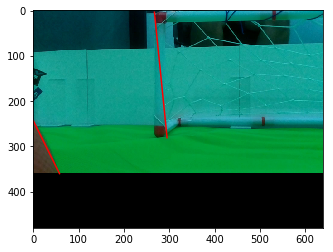

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
for b in bx1:
    x0,y0,x1,y1,c = b
    plt.plot((x0,x1),(y0,y1),color='r')
plt.imshow(im1)
plt.show()

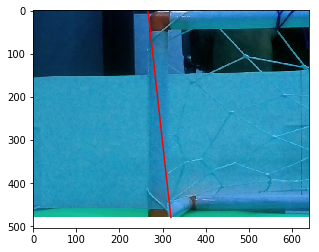

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(im)
for b in bx:
    x0,y0,x1,y1,c = b
    plt.plot((x0,x1),(y0,y1),color='r')
plt.show()

In [6]:
from mc3train import mysequence,get_classes,get_anchors
import json
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [7]:
json_path = "../annotations/MC3_val.json"
im_dir = "/data/mc_data/images_12k/"
f = open(json_path,'r')
info = json.load(f)
f.close()
anchors_path = './model_data/yolo_anchors.txt'
class_path = './model_data/mc3_classes.txt'

In [8]:
anchors = get_anchors(anchors_path)
class_names = get_classes(class_path)
num_classes = len(class_names)
ge = mysequence(im_dir,info,1,(640,480),anchors,num_classes)

In [4]:
it = iter(ge)

In [5]:
re,_ = next(it)

In [6]:
print(re[0].shape,re[1].shape,re[2].shape,re[3].shape)

(1, 640, 640, 3) (1, 20, 20, 3, 8) (1, 40, 40, 3, 8) (1, 80, 80, 3, 8)


In [50]:
import numpy as np
np.sum(re[2][0][18])

NameError: name 're' is not defined

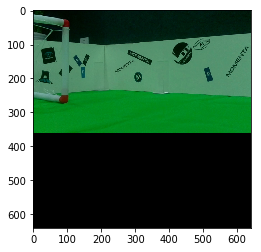

In [26]:
plt.imshow(re[0][0])
plt.show()

In [51]:
new_b = np.expand_dims(bx1,0)
new_b.shape

(1, 5, 5)

In [52]:
input_shape = (640,480)
anchors

array([[ 10.,  13.],
       [ 16.,  30.],
       [ 33.,  23.],
       [ 30.,  61.],
       [ 62.,  45.],
       [ 59., 119.],
       [116.,  90.],
       [156., 198.],
       [373., 326.]])

In [53]:
import numpy as np

In [58]:
def preprocess_true_boxes(true_boxes, input_shape, anchors, num_classes):
    '''Preprocess true boxes to training input format

    Parameters
    ----------
    true_boxes: array, shape=(m, T, 5)
        Absolute x_min, y_min, x_max, y_max, class_id relative to input_shape.
    input_shape: array-like, hw, multiples of 32
    anchors: array, shape=(N, 2), wh
    num_classes: integer

    Returns
    -------
    y_true: list of array, shape like yolo_outputs, xywh are reletive value

    '''
    assert (true_boxes[..., 4]<num_classes).all(), 'class id must be less than num_classes'
    num_layers = len(anchors)//3 # default setting
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

    true_boxes = np.array(true_boxes, dtype='float32')
    input_shape = np.array(input_shape, dtype='int32')
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]
    true_boxes[..., 0:2] = boxes_xy/input_shape[::-1]
    true_boxes[..., 2:4] = boxes_wh/input_shape[::-1]

    m = true_boxes.shape[0]
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)]
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)]

    # Expand dim to apply broadcasting.
    anchors = np.expand_dims(anchors, 0)
    anchor_maxes = anchors / 2.
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0]>0

    for b in range(m):
        # Discard zero rows.
        wh = boxes_wh[b, valid_mask[b]]
        if len(wh)==0: continue
        # Expand dim to apply broadcasting.
        wh = np.expand_dims(wh, -2)
        box_maxes = wh / 2.
        box_mins = -box_maxes

        intersect_mins = np.maximum(box_mins, anchor_mins)
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        # Find best anchor for each true box
        best_anchor = np.argmax(iou, axis=-1)
        print(true_boxes,grid_shapes)
        for t, n in enumerate(best_anchor):
            for l in range(num_layers):
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0]*grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1]*grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    print(b,j,i,k,y_true[l].shape)
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1

    return y_true

In [59]:
y_ = preprocess_true_boxes(new_b,(640,480),anchors,num_classes)

[[[ 0.05833333  0.4703125   0.12046027  0.18203883  0.        ]
  [ 0.5854167   0.221875    0.05821807  0.43279395  2.        ]
  [-0.         -0.          0.          0.          0.        ]
  [-0.         -0.          0.          0.          0.        ]
  [-0.         -0.          0.          0.          0.        ]]] [array([20, 15], dtype=int32), array([40, 30], dtype=int32), array([80, 60], dtype=int32)]
0 18 1 2 (1, 40, 30, 3, 8)
0 8 17 2 (1, 40, 30, 3, 8)
